# Testing a simple workflow

- Import dataset, do some clean up, fix scitypes
- Unpack predictors and response variable
- Load a ridge regressor model
- Create a pipeline with the following steps:
    - Standardize all continuous predictors
    - One hot encode all multiclass predictors
    - Transform target using log
    - Inverse target using exp

In [1]:
using MLJ, MLJBase, CSV, DataFrames, CairoMakie

In [2]:
# Import training dataset
lichen_training = CSV.read("C:/Users/julio/Downloads/lichen_training.csv", DataFrame; missingstring="NA") |>
dropmissing |>
x -> DataFrames.select(x, "Total.lichen", "basal_area", "PL", "mean_Long", "mean_Lat", "SX", "SNR") |>
x -> rename(x, ["biomass", "basalarea", "pl", "lon", "lat", "sx", "snr"]) |>
x -> coerce(x, Count => Continuous, Textual => Multiclass)

,biomass,basalarea,pl,lon,lat,sx,snr
,Float64,Float64,Float64,Float64,Float64,Float64,Cat…
1,3.3,5.52,0.0,-124.205,55.2704,0.0,B
2,1.97,10.44,0.0,-124.202,55.2649,60.0,C
3,1158.52,16.42,100.0,-124.633,55.4289,0.0,C
4,3474.61,7.77,100.0,-124.622,55.4232,0.0,C
5,1.72,22.54,0.0,-124.625,55.4193,60.0,C
6,3462.56,15.24,100.0,-124.64,55.4299,0.0,C
7,1.93,30.54,0.0,-124.33,55.3043,0.0,C
8,3.53,16.0,0.0,-124.323,55.3038,0.0,C
9,1.56,36.82,0.0,-124.323,55.3021,80.0,C


In [3]:
# Unpack predictors and response variable
y, X = unpack(lichen_training, ==(:biomass), _->true);

In [12]:
# Ridge Regressor Model
model = @load RidgeRegressor pkg=MLJLinearModels verbosity=0
pipe = @pipeline Standardizer OneHotEncoder model target=x -> log.(x) inverse=x -> exp.(x)
r = range(pipe, :(ridge_regressor.lambda), lower=0.1, upper=10)
tunned = TunedModel(model=pipe, ranges=r, tuning=Grid(resolution=50), resampling=CV(nfolds=3, rng=4141), measure=rms)
mach = machine(tunned, X, y)
fit!(mach)

best = fitted_params(mach).best_model
best.ridge_regressor.lambda

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\composition\models\pipelines.jl:372
┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Attempting to evaluate 50 models.
└ @ MLJTuning C:\Users\julio\.julia\packages\MLJTuning\bjRHJ\src\tuned_models.jl:680
Evaluating over 50 metamodels:   4%[=>                       ]  ETA: 0:00:46

Evaluating over 50 metamodels:   6%[=>                       ]  ETA: 0:00:30

Evaluating over 50 metamodels:   8%[==>                      ]  ETA: 0:00:22

Evaluating over 50 metamodels:  10%[==>                      ]  ETA: 0:00:17

Evaluating over 50 metamodels:  12%[===>                     ]  ETA: 0:00:14

Evaluating over 50 metamodels:  14%[===>                     ]  ETA: 0:00:12

Evaluating over 50 metamodels:  16%[====>                    ]  ETA: 0:00:10

Evaluating over 50 metamodels:  18%[====>                    ]  ETA: 0:00:09

Evaluating over 50 metamodels:  20%[=====>                   ]  ETA: 0:00:08

Evaluating over 50 metamodels:  22%[=====>                   ]  ETA: 0:00:07

Evaluating over 50 metamodels:  24%[======>                  ]  ETA: 0:00:06

Evaluating over 50 metamodels:  26%[======>                  ]  ETA: 0:00:06

Evaluating over 50 metamodels:  28%[=======>                 ]  ETA: 0:00:05

Evaluating over 50 metamodels:  30%[=======>                 ]  ETA: 0:00:05

Evaluating over 50 metamodels:  32%[========>                ]  ETA: 0:00:04

Evaluating over 50 metamodels:  34%[========>                ]  ETA: 0:00:04

Evaluating over 50 metamodels:  36%[=========>               ]  ETA: 0:00:04

Evaluating over 50 metamodels:  38%[=========>               ]  ETA: 0:00:03

Evaluating over 50 metamodels:  40%[==========>              ]  ETA: 0:00:03

Evaluating over 50 metamodels:  42%[==========>              ]  ETA: 0:00:03

Evaluating over 50 metamodels:  44%[===========>             ]  ETA: 0:00:03

Evaluating over 50 metamodels:  46%[===========>             ]  ETA: 0:00:03

Evaluating over 50 metamodels:  48%[============>            ]  ETA: 0:00:02

Evaluating over 50 metamodels:  50%[============>            ]  ETA: 0:00:02

Evaluating over 50 metamodels:  52%[=============>           ]  ETA: 0:00:02

Evaluating over 50 metamodels:  54%[=============>           ]  ETA: 0:00:02

Evaluating over 50 metamodels:  56%[==============>          ]  ETA: 0:00:02

Evaluating over 50 metamodels:  58%[==============>          ]  ETA: 0:00:02

Evaluating over 50 metamodels:  60%[===============>         ]  ETA: 0:00:02

Evaluating over 50 metamodels:  62%[===============>         ]  ETA: 0:00:01

Evaluating over 50 metamodels:  66%[================>        ]  ETA: 0:00:01

Evaluating over 50 metamodels:  68%[=================>       ]  ETA: 0:00:01

Evaluating over 50 metamodels:  70%[=================>       ]  ETA: 0:00:01

Evaluating over 50 metamodels:  72%[==================>      ]  ETA: 0:00:01

Evaluating over 50 metamodels:  76%[===================>     ]  ETA: 0:00:01

Evaluating over 50 metamodels:  78%[===================>     ]  ETA: 0:00:01

Evaluating over 50 metamodels:  80%[====================>    ]  ETA: 0:00:01

Evaluating over 50 metamodels:  82%[====================>    ]  ETA: 0:00:01

Evaluating over 50 metamodels:  84%[=====================>   ]  ETA: 0:00:00

Evaluating over 50 metamodels:  86%[=====================>   ]  ETA: 0:00:00

Evaluating over 50 metamodels:  88%[======================>  ]  ETA: 0:00:00

Evaluating over 50 metamodels:  90%[======================>  ]  ETA: 0:00:00

Evaluating over 50 metamodels:  92%[=======================> ]  ETA: 0:00:00

Evaluating over 50 metamodels:  96%[========================>]  ETA: 0:00:00

Evaluating over 50 metamodels:  98%[========================>]  ETA: 0:00:00

Evaluating over 50 metamodels: 100%[=========================] Time: 0:00:02


3.130612244897959

In [13]:
# Get the fitted parameters
fp = fitted_params(mach);

In [15]:
# Regressor coefficients
fp

(best_model = Pipeline306,
 best_fitted_params = (inverse = (fitresult = nothing,),
                       ridge_regressor = (coefs = [:basalarea => -0.6905307788073289, :pl => 0.916804772865311, :lon => -0.8373423878482915, :lat => 0.12049581373939725, :sx => 0.12586070726639248, :snr__A => 0.6273249652049521, :snr__B => 1.655554499410423, :snr__C => 1.0995830130862663],
                                          intercept = 3.3824624777016474,),
                       one_hot_encoder = (fitresult = OneHotEncoderResult,),
                       standardizer = Dict(:basalarea => (19.905974025974025, 9.59526339559761), :sx => (9.883116883116884, 23.760301935201667), :lat => (55.97332400649351, 0.5664634649325857), :pl => (57.05194805194805, 43.025052709193105), :lon => (-125.32716337662336, 0.8816506583042382)),
                       target = (fitresult = nothing,),
                       machines = Machine[Machine{WrappedFunction,…}, Machine{Standardizer,…}, Machine{OneHotEncoder,…}, M

In [17]:
# Predict
yhat = predict(mach)
@show rms(yhat, y)^2;

rms(yhat, y) ^ 2 = 1.0913891573717303e6


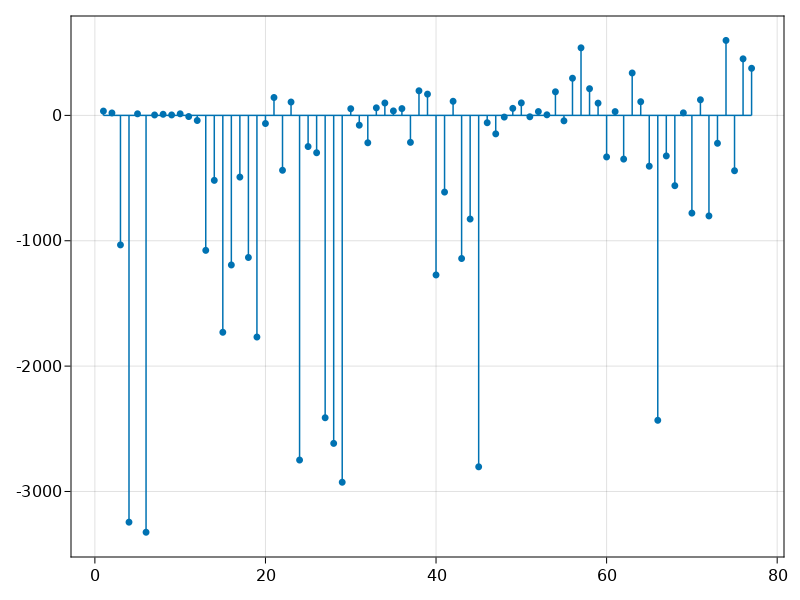

In [18]:
# Residuals
stem(yhat - y)

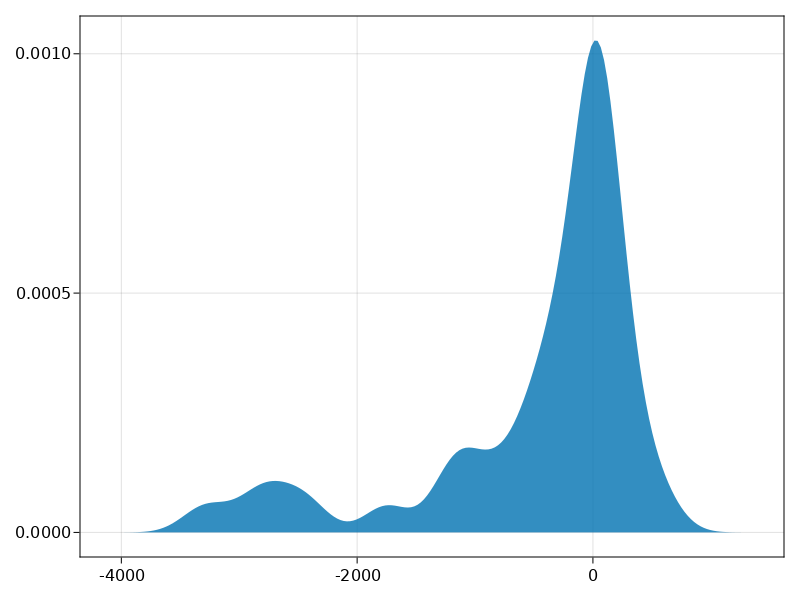

In [19]:
# Residuals density
density(yhat - y)